# Build an app to find cheap airfares


In [1]:
#import the libraries
import pandas as pd
import numpy as np
 
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
 
from bs4 import BeautifulSoup
 
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
#instantiate the browser object

url = "https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HKG;s=0;li=14;lx=20;d=2017-06-01"
 
driver = webdriver.PhantomJS()
 
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
 
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])

driver.implicitly_wait(20)
driver.get(url)

In [25]:
#take a screenshot
driver.save_screenshot(r'flight_explorer.png')


True

In [26]:
#Feed the page source to BeautifulSoup
s = BeautifulSoup(driver.page_source, "lxml")

In [27]:
#Retrieve a list of all the best prices
best_price_tags = s.findAll('div', 'LJTSM3-w-e')
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace('$','')))

In [28]:
#Cheapest price should be first element
best_price = best_prices[0]
print(best_price)

767


In [29]:
#Get the list of bar heights for each
best_height_tags = s.findAll('div', 'LJTSM3-w-f')
best_heights = []
for t in best_height_tags:
    best_heights.append(float(t.attrs['style']\
    .split('height:')[1].replace('px;','')))

In [30]:
#Get the cheapest one
best_height = best_heights[0]

In [31]:
#calculate the price per pixel of the height
pph = np.array(best_price)/np.array(best_height)

In [32]:
#retrieve the bar heights for all flights in each city
cities = s.findAll('div', 'LJTSM3-w-o')
 
hlist=[]
for bar in cities[0]\
    .findAll('div', 'LJTSM3-w-x'):
    hlist.append(float(bar['style']\
                       .split('height: ')[1]\
                       .replace('px;',''))*pph)
fares = pd.DataFrame(hlist, columns=['price'])

In [33]:
# DataFrame with the cheapest fare for a two-month period
fares.min()

price    767.0
dtype: float64

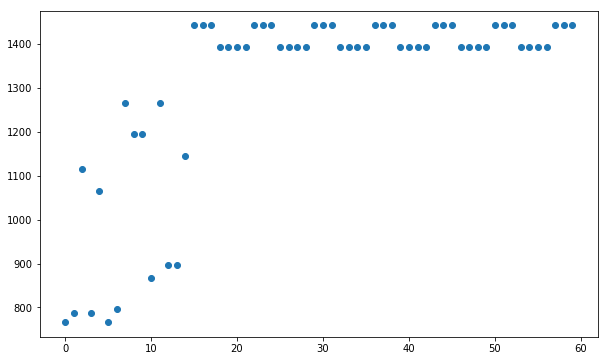

In [34]:
#Create a graph to plot fare prices
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(np.arange(len(fares['price'])),fares['price'])

We can see that the fare rise a lot start from end of Jun. And keep increasing during summer period.

In [35]:
#Set up a price frame that we can pass to the DBSCAN object:
px = [x for x in fares['price']]
ff = pd.DataFrame(px, columns=['fare']).reset_index()

In [36]:
#Import Libraries for clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/Users/sincheng/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


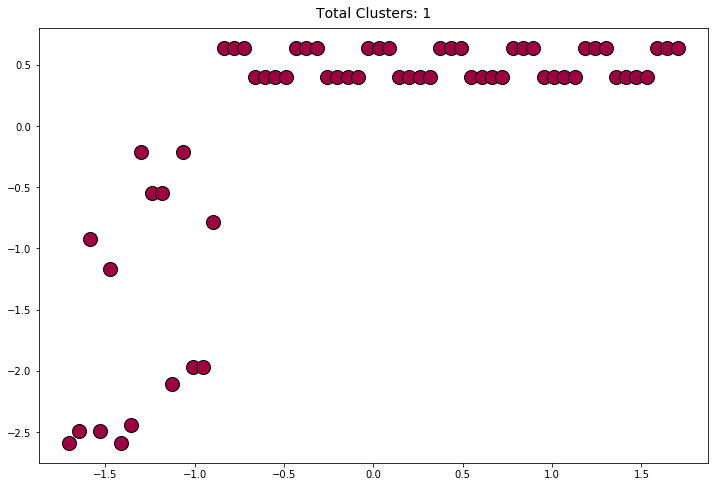

In [41]:
#apply the DBSCAN algorithm to our fare data and output a visualization
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps=1.0, min_samples=1).fit(X)
 
labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
 
plt.subplots(figsize=(12,8))
 
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
            markeredgecolor='k', markersize=14)
 
plt.title("Total Clusters: {}".format(clusters), fontsize=14,
        y=1.01)


The algorithm has identified four distinct clusters,

In [27]:
pf = pd.concat([ff, pd.DataFrame(db.labels_, 
                                columns=['cluster'])], axis=1) 
pf

,index,fare,cluster
0,0,733.403450,0
1,1,783.454186,0
2,2,752.222527,0
3,3,730.000000,0
4,4,730.000000,0
5,5,730.000000,0
6,6,730.000000,0
7,7,733.403450,0
8,8,783.454186,0
9,9,783.454186,0


In [28]:
#Group by cluster and retrieve the minimum price:
rf = pf.groupby('cluster')['fare'].agg(['min','count']) 
rf

,min,count
cluster,,
0,730.0,60


In [22]:
#
rf.describe([.10,.25,.5,.75,.9])

,min,count
count,4.000000,4.000000
mean,985.909415,15.000000
std,179.650019,26.670833
min,730.000000,1.000000
10%,810.061158,1.300000
25%,930.152895,1.750000
50%,1040.314565,2.000000
75%,1096.071086,15.250000
90%,1118.233552,39.100000
max,1133.008529,55.000000


Outlier detection rules:<br>
1.Mistake price should be equal to the lowest price displayed
2.Set the mistake cluster will be smaller than the main cluster
3.Set a minimum distance between the lowest priced cluster and the second lowest priced